# Conv-LSTM Travel-Time-Rate included

In [1]:
#libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, Conv2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
# Load the taxi data with demand and travel time rate
df = pd.read_parquet(r"C:\Users\justu\OneDrive\Desktop\Thesis\2009 taxi data\4. Taxi Data Square Grids and Weather\final.parquet")
df['Trip_Pickup_DateTime'] = pd.to_datetime(df['Trip_Pickup_DateTime'])
df = df[['Trip_Pickup_DateTime', 'grid_cell_id', 'demand', 'time_travel_rate']]
df['grid_cell_id'] = df['grid_cell_id'].astype('int32')
df['demand'] = df['demand'].astype('float32')
df['time_travel_rate'] = df['time_travel_rate'].astype('float32')

In [6]:
# Map grid_cell_id to 2D grid coordinates
num_cols = 16
max_grid_id = df['grid_cell_id'].max()
num_rows = (max_grid_id // num_cols) + 1

df['grid_row'] = df['grid_cell_id'] // num_cols
df['grid_col'] = df['grid_cell_id'] % num_cols

In [8]:
# Create tensors for demand and travel time rate
time_index = df['Trip_Pickup_DateTime'].sort_values().unique()
tensor_demand = np.zeros((len(time_index), num_rows, num_cols), dtype=np.float32)
tensor_travel_time = np.zeros_like(tensor_demand)

# Populate tensors
for t, timestamp in enumerate(time_index):
    snapshot = df[df['Trip_Pickup_DateTime'] == timestamp]
    for _, row in snapshot.iterrows():
        row_idx = int(row['grid_row'])
        col_idx = int(row['grid_col'])
        if row_idx < num_rows and col_idx < num_cols:
            tensor_demand[t, row_idx, col_idx] = row['demand']
            tensor_travel_time[t, row_idx, col_idx] = row['time_travel_rate']

# Normalize the tensors
scaler_demand = MinMaxScaler()
tensor_demand_flat = tensor_demand.reshape(-1, 1)
tensor_demand_normalized = scaler_demand.fit_transform(tensor_demand_flat).reshape(tensor_demand.shape)

scaler_travel_time = MinMaxScaler()
tensor_travel_time_flat = tensor_travel_time.reshape(-1, 1)
tensor_travel_time_normalized = scaler_travel_time.fit_transform(tensor_travel_time_flat).reshape(tensor_travel_time.shape)

In [9]:
# Split into train, validation, and test sets
train_cutoff = int(0.7 * len(time_index))
val_cutoff = int(0.85 * len(time_index))

X_demand_train = tensor_demand_normalized[:train_cutoff]
X_demand_val = tensor_demand_normalized[train_cutoff:val_cutoff]
X_demand_test = tensor_demand_normalized[val_cutoff:]

X_travel_train = tensor_travel_time_normalized[:train_cutoff]
X_travel_val = tensor_travel_time_normalized[train_cutoff:val_cutoff]
X_travel_test = tensor_travel_time_normalized[val_cutoff:]

In [10]:
# Create sequences with look-back window Kd
Kd = 8

def create_sequences(data, Kd):
    X, y = [], []
    for t in range(Kd, len(data)):
        X.append(data[t-Kd:t])
        y.append(data[t])
    return np.array(X), np.array(y)

X_demand_train, y_train = create_sequences(X_demand_train, Kd)
X_demand_val, y_val = create_sequences(X_demand_val, Kd)
X_demand_test, y_test = create_sequences(X_demand_test, Kd)

X_travel_train, _ = create_sequences(X_travel_train, Kd)
X_travel_val, _ = create_sequences(X_travel_val, Kd)
X_travel_test, _ = create_sequences(X_travel_test, Kd)

# Add channel dimension
X_demand_train = X_demand_train[..., np.newaxis]
X_demand_val = X_demand_val[..., np.newaxis]
X_demand_test = X_demand_test[..., np.newaxis]

X_travel_train = X_travel_train[..., np.newaxis]
X_travel_val = X_travel_val[..., np.newaxis]
X_travel_test = X_travel_test[..., np.newaxis]

y_train = y_train[..., np.newaxis]
y_val = y_val[..., np.newaxis]
y_test = y_test[..., np.newaxis]

In [11]:
# Define the model
input_demand = Input(shape=(Kd, num_rows, num_cols, 1))
input_travel = Input(shape=(Kd, num_rows, num_cols, 1))

# Separate ConvLSTM branches for demand and travel time rate
demand_branch = ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', return_sequences=False)(input_demand)
travel_branch = ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', return_sequences=False)(input_travel)

# Combine the branches
merged = Concatenate()([demand_branch, travel_branch])
output = Conv2D(filters=1, kernel_size=(3, 3), activation='relu', padding='same')(merged)

model = Model(inputs=[input_demand, input_travel], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8, 28, 16, 1)]       0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 8, 28, 16, 1)]       0         []                            
                                                                                                  
 conv_lstm2d (ConvLSTM2D)    (None, 28, 16, 64)           150016    ['input_1[0][0]']             
                                                                                                  
 conv_lstm2d_1 (ConvLSTM2D)  (None, 28, 16, 64)           150016    ['input_2[0][0]']             
                                                                                              

In [12]:
# Add a checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model_combined.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [13]:
# Train the model
history = model.fit(
    [X_demand_train, X_travel_train], y_train,
    validation_data=([X_demand_val, X_travel_val], y_val),
    batch_size=32,
    epochs=100,
    callbacks=[checkpoint_callback],
    verbose=1
)

Epoch 1/100
192/192 [==============================] - ETA: 0s - loss: 5.4078e-04 - mae: 0.0060
Epoch 1: val_loss improved from inf to 0.00024, saving model to best_model_combined.h5
192/192 [==============================] - 450s 2s/step - loss: 5.4078e-04 - mae: 0.0060 - val_loss: 2.4367e-04 - val_mae: 0.0037
Epoch 2/100


c:\Users\justu\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


192/192 [==============================] - ETA: 0s - loss: 1.7911e-04 - mae: 0.0033
Epoch 2: val_loss improved from 0.00024 to 0.00016, saving model to best_model_combined.h5
192/192 [==============================] - 425s 2s/step - loss: 1.7911e-04 - mae: 0.0033 - val_loss: 1.5811e-04 - val_mae: 0.0030
Epoch 3/100
192/192 [==============================] - ETA: 0s - loss: 1.2617e-04 - mae: 0.0028
Epoch 3: val_loss improved from 0.00016 to 0.00014, saving model to best_model_combined.h5
192/192 [==============================] - 413s 2s/step - loss: 1.2617e-04 - mae: 0.0028 - val_loss: 1.4179e-04 - val_mae: 0.0028
Epoch 4/100
192/192 [==============================] - ETA: 0s - loss: 1.0904e-04 - mae: 0.0026
Epoch 4: val_loss improved from 0.00014 to 0.00012, saving model to best_model_combined.h5
192/192 [==============================] - 411s 2s/step - loss: 1.0904e-04 - mae: 0.0026 - val_loss: 1.1584e-04 - val_mae: 0.0026
Epoch 5/100
192/192 [==============================] - ETA: 0

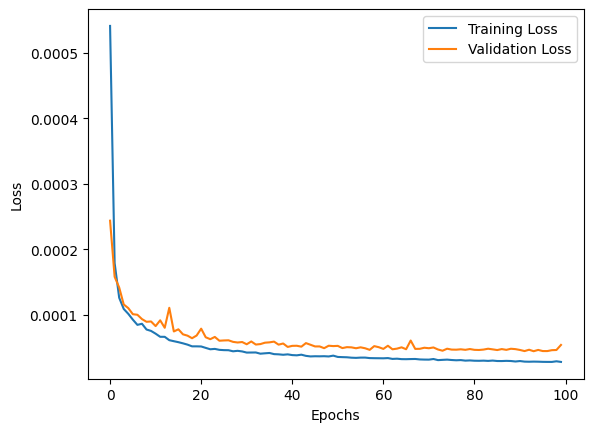

In [16]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the best model manually
model.save(r'C:\Users\justu\OneDrive\Desktop\Thesis\models\convlstm_with_time-travel-rate\best_model_combined.h5')
model.save(r'C:\Users\justu\OneDrive\Desktop\Thesis\models\convlstm_with_time-travel-rate\best_model_combined')

c:\Users\justu\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\justu\OneDrive\Desktop\Thesis\models\convlstm_with_time-travel-rate\best_model_combined\assets


INFO:tensorflow:Assets written to: C:\Users\justu\OneDrive\Desktop\Thesis\models\convlstm_with_time-travel-rate\best_model_combined\assets


In [17]:
from tensorflow.keras.models import load_model

# Load the best model saved by ModelCheckpoint
best_model = load_model('best_model_combined.h5')

In [19]:
# Evaluate the model
test_loss, test_mae = best_model.evaluate([X_demand_test, X_travel_test], y_test, verbose=1)

print(f"Test Loss (MSE): {test_loss}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")

41/41 [==============================] - 15s 365ms/step - loss: 4.2174e-05 - mae: 0.0015
Test Loss (MSE): 4.2174055124633014e-05
Test Mean Absolute Error (MAE): 0.001480719307437539


41/41 [==============================] - 15s 357ms/step


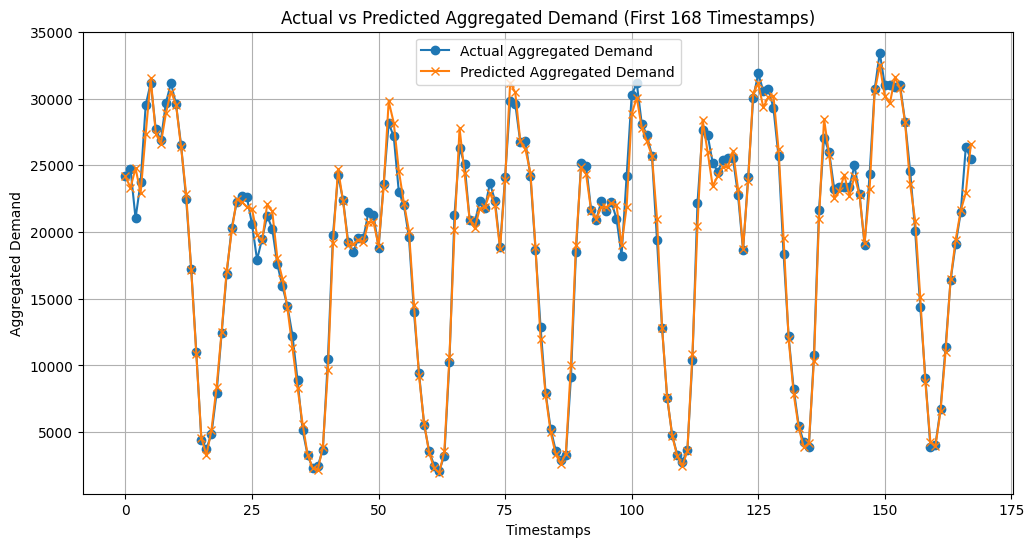

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
y_pred = best_model.predict([X_demand_test, X_travel_test])

# Denormalize the predictions and actual values
y_pred_denormalized = scaler_demand.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)
y_test_denormalized = scaler_demand.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# Aggregate demand (sum over all grid cells) for the first 168 timestamps
aggregated_y_pred = y_pred_denormalized[:168].sum(axis=(1, 2))  # Sum across grid dimensions
aggregated_y_test = y_test_denormalized[:168].sum(axis=(1, 2))  # Sum across grid dimensions

# Plot actual vs predicted aggregated demand
plt.figure(figsize=(12, 6))
plt.plot(aggregated_y_test, label="Actual Aggregated Demand", marker='o')
plt.plot(aggregated_y_pred, label="Predicted Aggregated Demand", marker='x')
plt.title("Actual vs Predicted Aggregated Demand (First 168 Timestamps)")
plt.xlabel("Timestamps")
plt.ylabel("Aggregated Demand")
plt.legend()
plt.grid()
plt.show()

In [21]:
import numpy as np

# Aggregate actual and predicted demand (sum over all grid cells) for each timestamp
aggregated_actual = y_test_denormalized.sum(axis=(1, 2))
aggregated_predicted = y_pred_denormalized.sum(axis=(1, 2))

# Filter for aggregated demand values >= 10
mask = aggregated_actual >= 10
filtered_actual = aggregated_actual[mask]
filtered_predicted = aggregated_predicted[mask]

# Calculate MAPE
mape = np.mean(np.abs((filtered_actual - filtered_predicted) / filtered_actual)) * 100

print(f"MAPE for aggregated demand values >= 10: {mape:.2f}%")

MAPE for aggregated demand values >= 10: 6.63%


In [22]:
import numpy as np

# Flatten the arrays to compute MAPE for all grid points
actual_flat = y_test_denormalized.flatten()
predicted_flat = y_pred_denormalized.flatten()

# Filter for demand values >= 10
mask = actual_flat >= 10
filtered_actual = actual_flat[mask]
filtered_predicted = predicted_flat[mask]

# Calculate MAPE
mape = np.mean(np.abs((filtered_actual - filtered_predicted) / filtered_actual)) * 100

print(f"MAPE for all grid cells with demand values >= 10: {mape:.2f}%")

MAPE for all grid cells with demand values >= 10: 22.75%


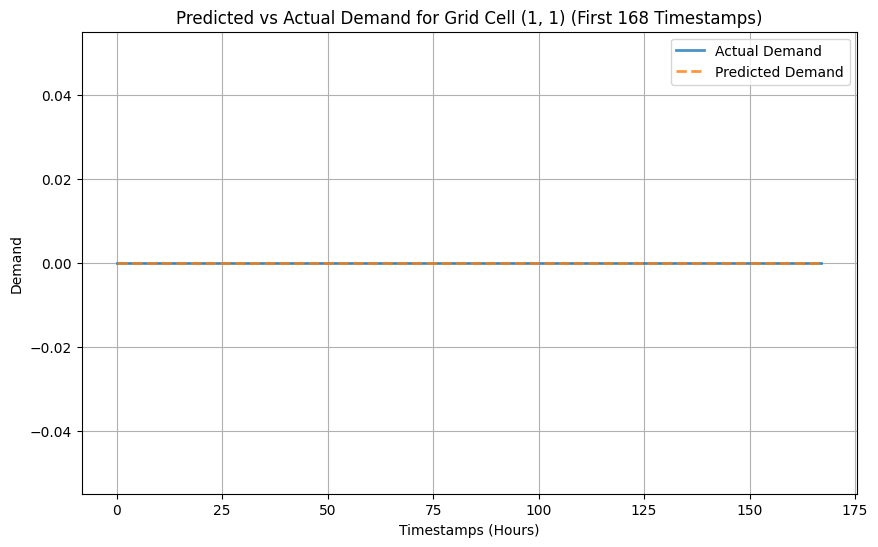

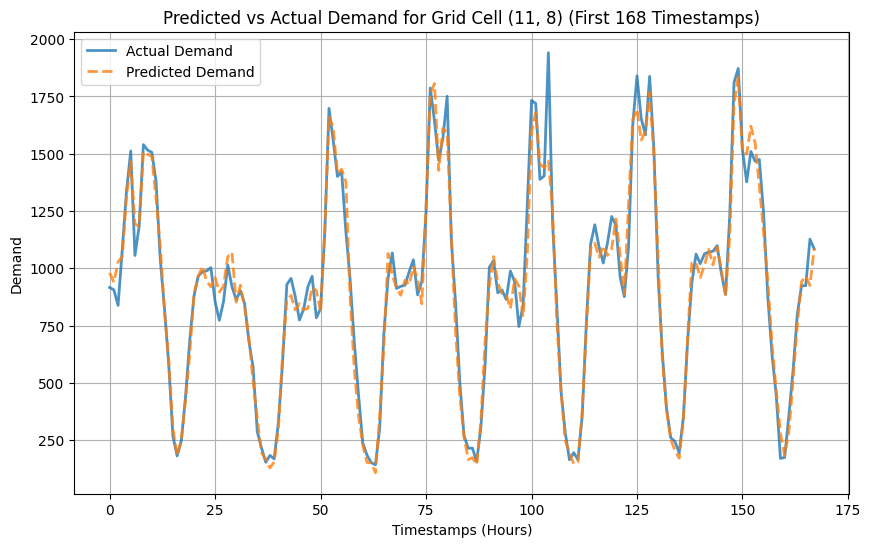

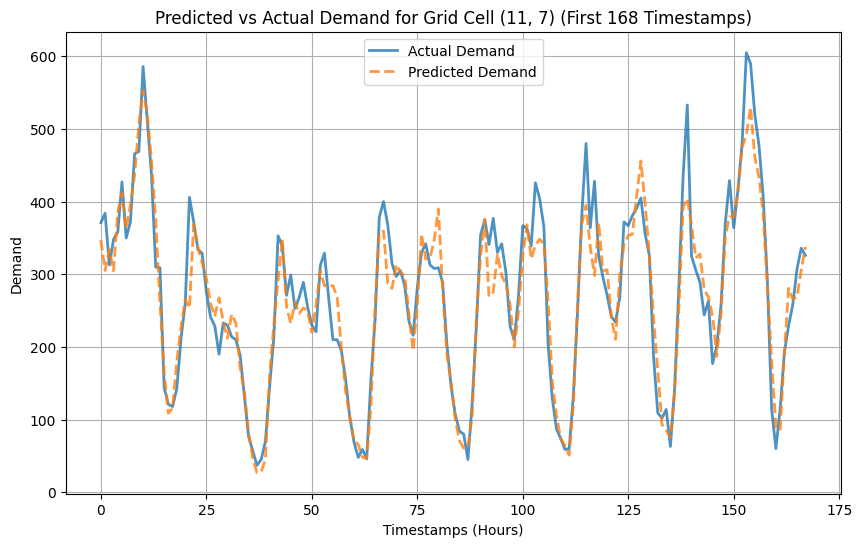

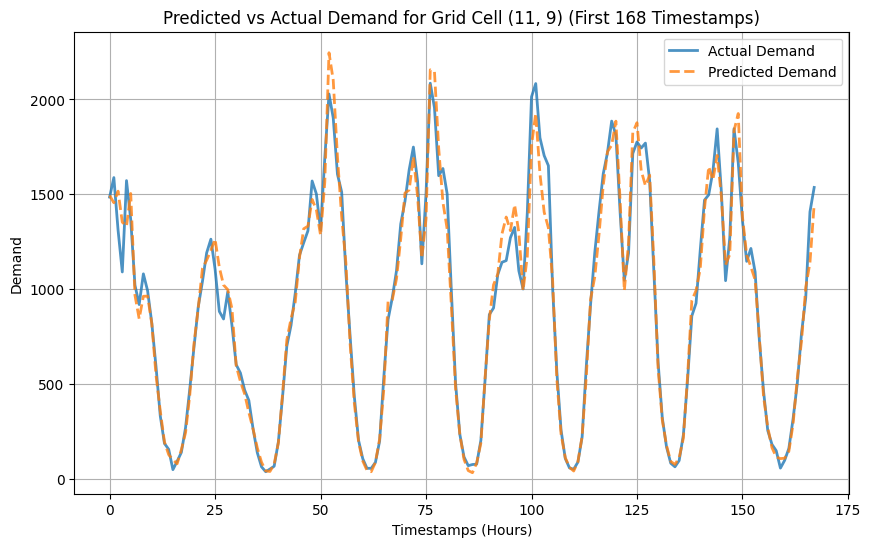

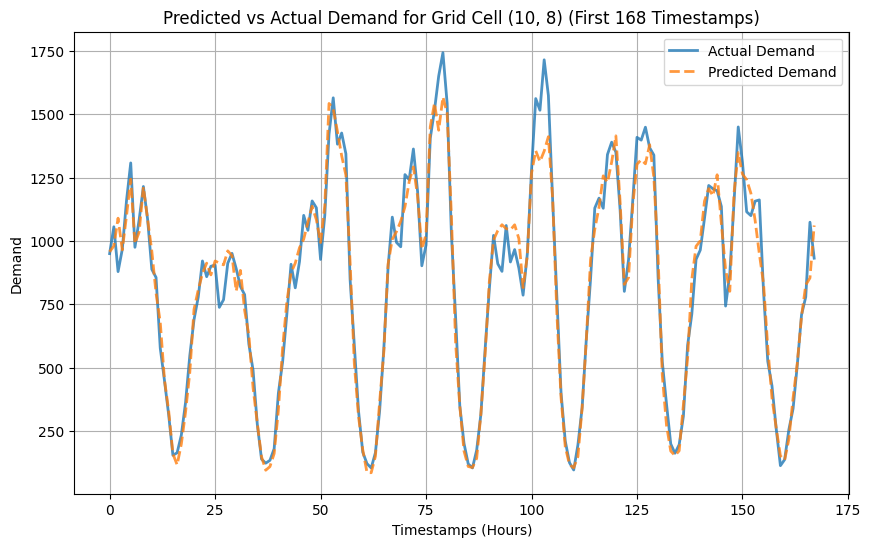

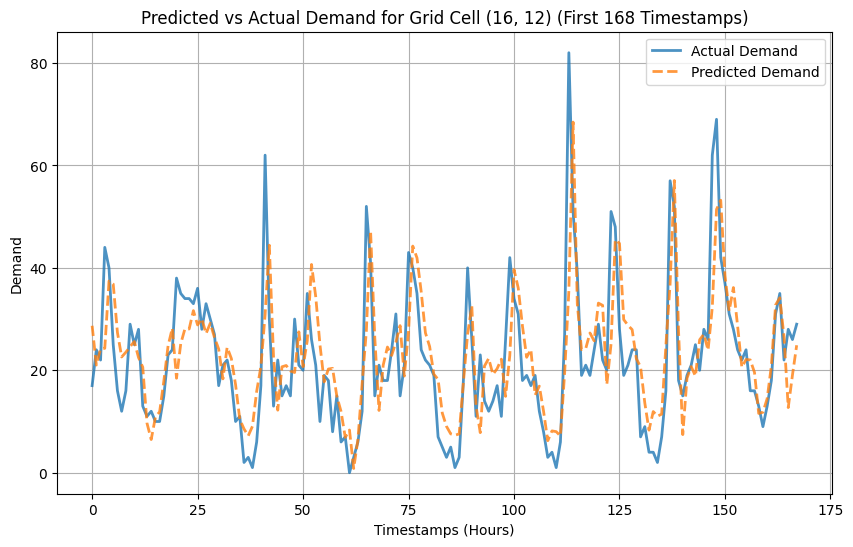

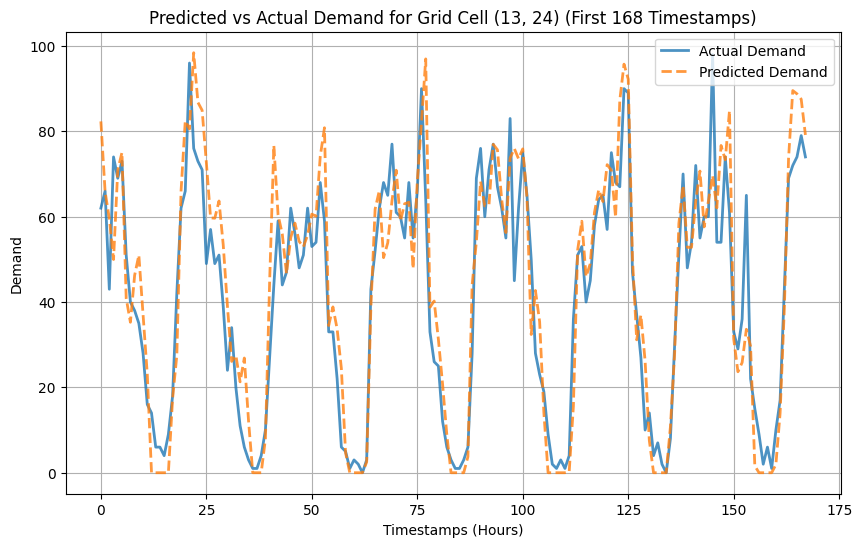

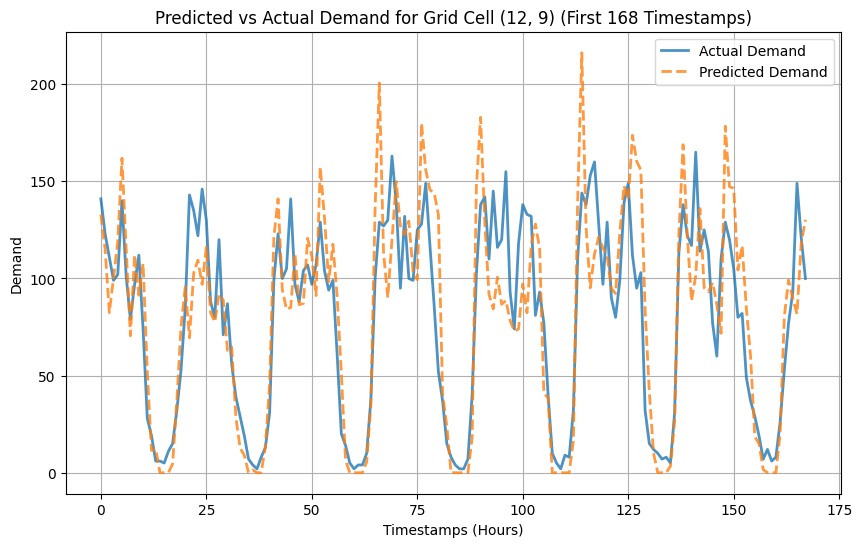

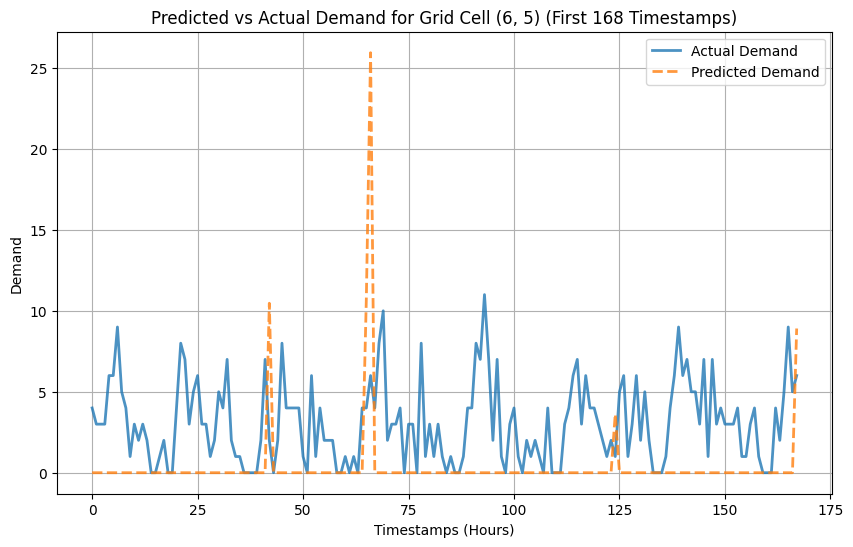

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the test and prediction arrays for denormalization
y_test_flat = y_test.reshape(y_test.shape[0], -1)  # Shape: (time_steps, num_rows * num_cols)
y_pred_flat = y_pred.reshape(y_pred.shape[0], -1)  # Shape: (time_steps, num_rows * num_cols)

# Inverse transform to original scale
y_test_original = scaler_demand.inverse_transform(y_test_flat)
y_pred_original = scaler_demand.inverse_transform(y_pred_flat)

# Define grid cells to analyze (row, column indices starting from 0)
grid_cells = [(1, 1), (11, 8), (11, 7), (11, 9), (10, 8), (16, 12), (13, 24), (12, 9), (6, 5)]  # List of (grid_row, grid_col)
timestamps_to_analyze = 168  # First 168 timestamps

# Loop through each grid cell
for grid_row, grid_col in grid_cells:
    # Calculate the corresponding grid cell index based on grid dimensions
    grid_cell = grid_row * num_cols + grid_col

    # Check if the grid cell index is valid
    if grid_cell >= y_test_original.shape[1]:
        print(f"Grid cell ({grid_row}, {grid_col}) is out of bounds. Skipping.")
        continue

    # Extract actual and predicted values for the grid cell
    actuals = y_test_original[:timestamps_to_analyze, grid_cell]
    preds = y_pred_original[:timestamps_to_analyze, grid_cell]

    # Plot predicted vs actual for this grid cell
    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label="Actual Demand", alpha=0.8, linewidth=2)
    plt.plot(preds, label="Predicted Demand", alpha=0.8, linestyle="dashed", linewidth=2)
    plt.title(f"Predicted vs Actual Demand for Grid Cell ({grid_row}, {grid_col}) (First 168 Timestamps)")
    plt.xlabel("Timestamps (Hours)")
    plt.ylabel("Demand")
    plt.legend()
    plt.grid()
    plt.show()

    demand_group       MAPE
0    Weakest 25%  93.326995
1        25%-50%  80.308514
2        50%-75%  32.705633
3  Strongest 25%  13.733047


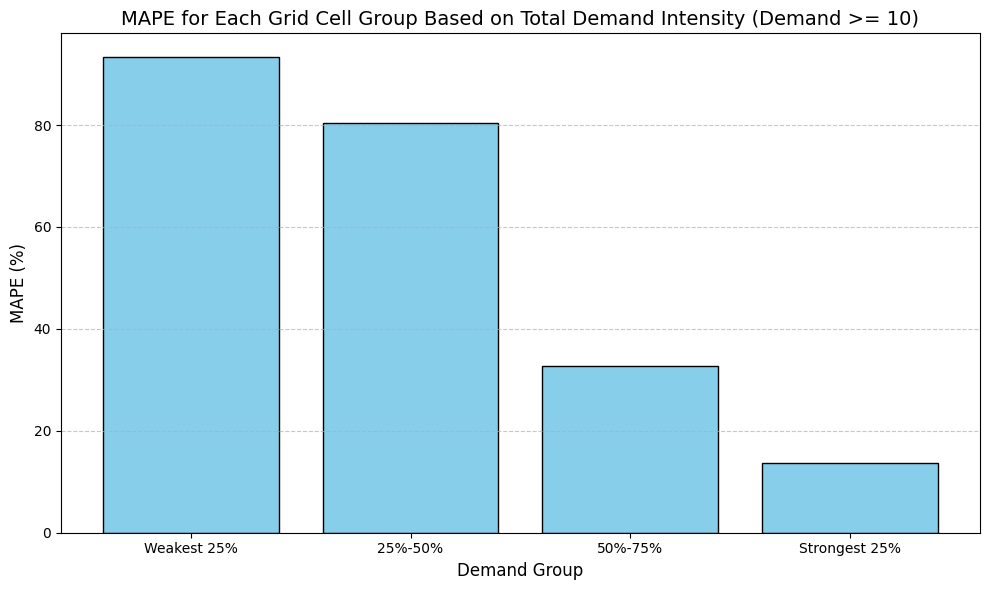

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Flatten the test and prediction arrays for denormalization
y_test_flat = y_test.reshape(y_test.shape[0], -1)  # Shape: (time_steps, num_rows * num_cols)
y_pred_flat = y_pred.reshape(y_pred.shape[0], -1)  # Shape: (time_steps, num_rows * num_cols)

# Inverse transform to original scale
y_test_original = scaler_demand.inverse_transform(y_test_flat)
y_pred_original = scaler_demand.inverse_transform(y_pred_flat)

# Compute total demand for each grid cell
total_demand = np.sum(y_test_original, axis=0)

# Create a DataFrame to hold grid cell data
grid_data = pd.DataFrame({
    "grid_cell_id": range(num_rows * num_cols),  # Update for num_rows and num_cols
    "total_demand": total_demand
})

# Exclude cells with zero total demand
grid_data = grid_data[grid_data["total_demand"] > 0]

# Divide remaining cells into 4 groups based on total demand (quartiles)
grid_data["demand_group"] = pd.qcut(
    grid_data["total_demand"], 
    4, 
    labels=["Weakest 25%", "25%-50%", "50%-75%", "Strongest 25%"]
)

# Update the MAPE calculation function to include only demand values >= 10
def compute_mape(actual, predicted):
    # Filter for actual demand values >= 10
    mask = actual >= 10
    actual = actual[mask]
    predicted = predicted[mask]

    # Compute MAPE if there are valid entries
    if len(actual) > 0:
        return np.mean(np.abs((actual - predicted) / actual)) * 100
    else:
        return np.nan  # Return NaN if no valid data

# Compute MAPE for each grid cell
mape_values = []
for grid_cell in grid_data["grid_cell_id"]:
    actuals = y_test_original[:, grid_cell]
    preds = y_pred_original[:, grid_cell]
    mape = compute_mape(actuals, preds)
    mape_values.append(mape)

# Add MAPE values to grid_data
grid_data["MAPE"] = mape_values

# Drop NaN MAPE values (if any grid cells had no valid data)
grid_data = grid_data.dropna(subset=["MAPE"])

# Calculate average MAPE for each group
grouped_mape = grid_data.groupby("demand_group")["MAPE"].mean().reset_index()

# Display the results
print(grouped_mape)

# Plot the MAPE for each group
plt.figure(figsize=(10, 6))
plt.bar(grouped_mape["demand_group"], grouped_mape["MAPE"], color="skyblue", edgecolor="black")
plt.title("MAPE for Each Grid Cell Group Based on Total Demand Intensity (Demand >= 10)", fontsize=14)
plt.xlabel("Demand Group", fontsize=12)
plt.ylabel("MAPE (%)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

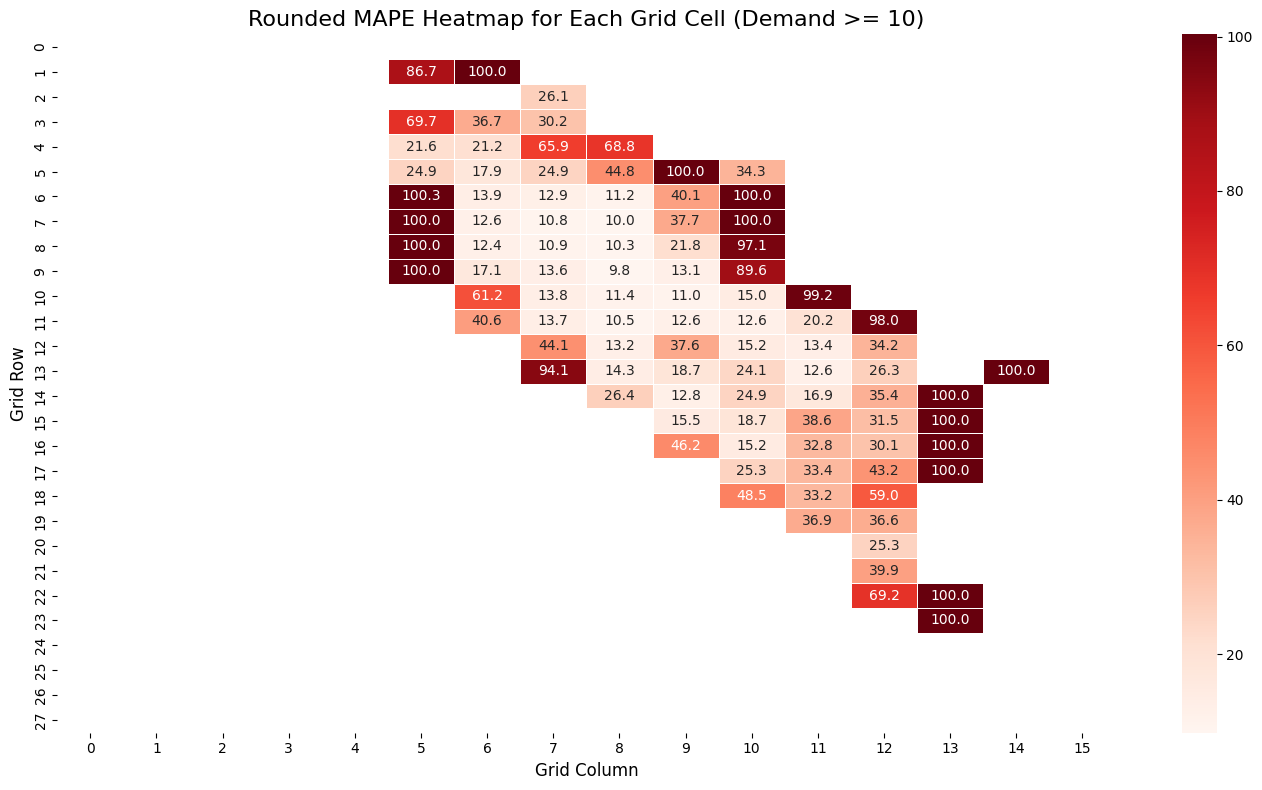

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten the test and prediction arrays for denormalization
y_test_flat = y_test.reshape(y_test.shape[0], -1)  # Shape: (time_steps, num_rows * num_cols)
y_pred_flat = y_pred.reshape(y_pred.shape[0], -1)  # Shape: (time_steps, num_rows * num_cols)

# Inverse transform to original scale
y_test_original = scaler_demand.inverse_transform(y_test_flat)
y_pred_original = scaler_demand.inverse_transform(y_pred_flat)

# Compute total demand for each grid cell
total_demand = np.sum(y_test_original, axis=0)

# Filter out grid cells with zero total demand
valid_cells = total_demand > 0

# Compute MAPE for each valid grid cell
def compute_mape(actual, predicted):
    # Filter for demand values >= 10
    mask = actual >= 10
    actual = actual[mask]
    predicted = predicted[mask]

    # Compute MAPE if there are valid entries
    if len(actual) > 0:
        return np.mean(np.abs((actual - predicted) / actual)) * 100
    else:
        return np.nan  # Return NaN if no valid data

mape_values = []
for grid_cell in range(num_rows * num_cols):
    if valid_cells[grid_cell]:
        actuals = y_test_original[:, grid_cell]
        preds = y_pred_original[:, grid_cell]
        mape = compute_mape(actuals, preds)
        mape_values.append(mape)
    else:
        mape_values.append(np.nan)  # Assign NaN for invalid cells

# Reshape MAPE values into a 2D grid
mape_grid = np.array(mape_values).reshape(num_rows, num_cols)

# Round MAPE values for better visualization
mape_grid_rounded = np.round(mape_grid, 1)

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(mape_grid_rounded, annot=True, fmt=".1f", cmap="Reds", cbar=True, linewidths=0.5)
plt.title("Rounded MAPE Heatmap for Each Grid Cell (Demand >= 10)", fontsize=16)
plt.xlabel("Grid Column", fontsize=12)
plt.ylabel("Grid Row", fontsize=12)
plt.tight_layout()
plt.show()